# Music Reviews:

## Intro
This report will look at several music review publishers. What music do they focus on? Although they both use a 0-10 numeric scoring system, does one use give higher average marks?

### Description of Data

For this report I will import a set of records describing music reviews by Anthony Fantano obtained from Kaggle [here](https://www.kaggle.com/jaredarcilla/anthony-fantano-reviews), and a set of music review scores from Pitchfork Music, also obtained from Kaggle, [here](https://www.kaggle.com/nolanbconaway/pitchfork-data). Anthony Fanato is an independant music reviewer who uploads his reviews to Youtube, which is where the data was originally obtained (not by me). Pitchfork is a music news and reviews publication, part of Condé Nast. 

The aspects of the data I will be focusing on are the review scores for albums. Both score albums on a 0-10 scale, with 10 as the best. I will be considering the degree to which they overlap

In [1]:
#importing modules 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import sqlite3
import json

## Importing and Cleaning Data

### Fantano Reviews

In [2]:
#loading first dataset
fantano_reviewdf = pd.read_csv('C:/Users/Chris/Documents/thinkful/thinkful_notes/music_caps/fantano_reviews.csv', encoding='latin_1')

In [3]:
#remove nulls
fantano_reviewdf = fantano_reviewdf[fantano_reviewdf['score'].notnull()]
fantano_reviewdf.head(3)

,Unnamed: 0,title,artist,review_date,review_type,score,word_score,best_tracks,worst_track,link
0,0,Cosmogramma,Flying Lotus,2010-05-05,Album,8.0,NaN,[],NaN,https://www.youtube.com/watch?v=KCuamde9Atc
1,1,Throat,Little Women,2010-05-09,Album,9.0,NaN,[],NaN,https://www.youtube.com/watch?v=cndwH6byJnk
2,2,Latin,Holy Fuck,2010-05-10,Album,7.0,NaN,[],NaN,https://www.youtube.com/watch?v=ySXryTlo9Ac


### Loading Pitchfork Dataset

In [4]:
#load pitchfork database
conn = sqlite3.connect('C:/Users/Chris/Documents/thinkful/thinkful_notes/music_caps/pf_database.sqlite')
c = conn.cursor()

In [5]:
#read pf reviews into a dataframe
pf_reviews_df = pd.read_sql('SELECT reviewid, title, artist ,score, best_new_music FROM reviews', conn)

In [6]:
#check data is in dataframe
pf_reviews_df.head(4)

,reviewid,title,artist,score,best_new_music
0,22703,mezzanine,massive attack,9.3,0
1,22721,prelapsarian,krallice,7.9,0
2,22659,all of them naturals,uranium club,7.3,0
3,22661,first songs,"kleenex, liliput",9.0,1


In [7]:
#add genre data to dataframe
pf_reviews_df_genre = pd.read_sql('SELECT * FROM genres', conn)
pf_reviews_df = pd.merge(pf_reviews_df, pf_reviews_df_genre, on='reviewid', how='inner')

In [8]:
#get summary data by genre
pf_bygenre_df = pf_reviews_df.groupby(['genre'])['score'].agg({'mean':np.mean, 'standard_d':np.std, 'count':np.size})
pf_bygenre_df

c:\users\chris\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


,mean,standard_d,count
genre,,,
electronic,6.920702,1.310056,3874.0
experimental,7.336694,1.106455,1815.0
folk/country,7.202190,1.064435,685.0
global,7.429680,1.006076,219.0
jazz,7.303908,1.251104,435.0
metal,6.950000,1.387799,862.0
pop/r&b,6.883799,1.295232,1432.0
rap,6.900513,1.302703,1559.0
rock,6.942011,1.360347,9438.0


## Analytic Questions

### Review Selection

Pitchfork - what does the review score distribution look like? Does this vary by genre?

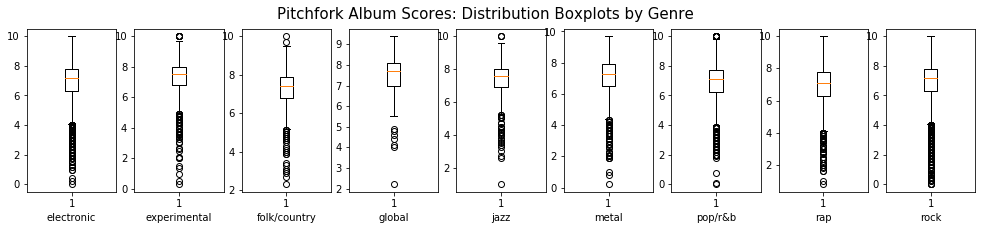

In [9]:
#plots of individual genre's score distribution
fig2 = plt.figure(figsize=(17,3))
plt.ylabel('Score')
plt.suptitle('Pitchfork Album Scores: Distribution Boxplots by Genre', fontsize=15)

for genreno, genreiter in enumerate(pf_bygenre_df.itertuples(index=True)):
    genrei = genreiter.Index
    plt.subplot(1, len(pf_bygenre_df.index), genreno+1)
    genreset = pf_reviews_df[pf_reviews_df['genre'] == genrei]['score'] #get scores for genre
    plt.boxplot(genreset)
    plt.xlabel(genrei)
plt.show(fig2)    

In [10]:
#Genre standard deviations
genre_std = pf_reviews_df.groupby(['genre'])['score'].std()
genre_std.sort_values(ascending=False)

genre
metal           1.387799
rock            1.360347
electronic      1.310056
rap             1.302703
pop/r&b         1.295232
jazz            1.251104
experimental    1.106455
folk/country    1.064435
global          1.006076
Name: score, dtype: float64

While generally similar, with most scores between 6 and 8, the standard deviation for rock albums is larger (though smaller than metal).  
Pitchfork's focus is on rock music, and so I will look at rock compared to all other genres. 

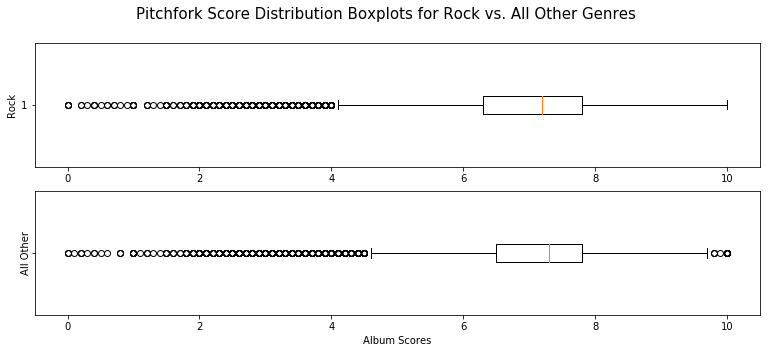

In [11]:
#plot Rock vs Other
pf_rock = pf_reviews_df[pf_reviews_df['genre'] == 'rock']
pf_nonrock = pf_reviews_df[pf_reviews_df['genre'] != 'rock']

fig3 = plt.figure(figsize=(13,5))
plt.ylabel('Score')
plt.suptitle('Pitchfork Score Distribution Boxplots for Rock vs. All Other Genres', fontsize=15)

ax1 = plt.subplot(211)
plt.boxplot(pf_rock['score'], vert=False)
plt.ylabel('Rock')

ax2 = plt.subplot(212,  sharey=ax1)
plt.boxplot(pf_nonrock['score'], vert=False)
plt.ylabel('All Other')
plt.setp(ax2.get_yticklabels(), visible=False)
plt.xlabel('Album Scores')    
plt.show(fig3)    

### Comparison of Review Scores between Pitchfork and Fantano

I will join these two datasets to look at just those albums which both reviewers have published scores for. 

In [13]:
#create lower case Artist and Album name columns in Fantano dataframe so they can be used to join Dataframes
fantano_reviewdf['artist_lc'] = fantano_reviewdf['artist'].str.lower()
fantano_reviewdf['title_lc'] = fantano_reviewdf['title'].str.lower()

In [14]:
# join Fantano and PF datasets
Fantano_PF_intersec_df = pd.merge(fantano_reviewdf, pf_reviews_df, 
                               left_on=['artist_lc','title_lc'], right_on=['artist','title'], 
                               how='inner', suffixes=('_Fantano', '_pf'))
#remove unusued columns
Fantano_PF_intersec_df = Fantano_PF_intersec_df.drop(['Unnamed: 0', 'review_date', 'review_type', 'word_score', 
                                                      'best_tracks', 'worst_track', 'link', 'reviewid'], axis=1)
# check data is correctly joined
Fantano_PF_intersec_df.head()

,title_Fantano,artist_Fantano,score_Fantano,artist_lc,title_lc,title_pf,artist_pf,score_pf,best_new_music,genre
0,Cosmogramma,Flying Lotus,8.0,flying lotus,cosmogramma,cosmogramma,flying lotus,8.8,1,electronic
1,Latin,Holy Fuck,7.0,holy fuck,latin,latin,holy fuck,7.8,0,electronic
2,High Violet,The National,6.0,the national,high violet,high violet,the national,8.7,1,rock
3,Together,The New Pornographers,7.0,the new pornographers,together,together,the new pornographers,7.3,0,rock
4,Sea of Cowards,The Dead Weather,5.0,the dead weather,sea of cowards,sea of cowards,the dead weather,7.8,0,rock


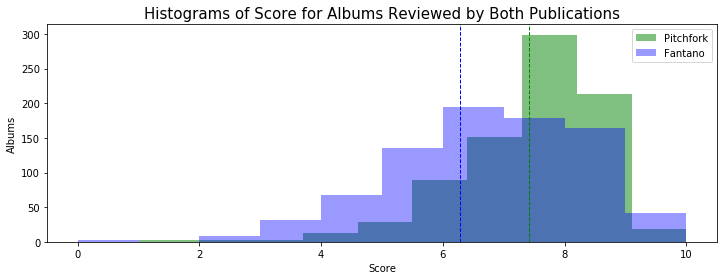

In [15]:
#plot histograms for review scores for mutually reviewed albums 
plt.figure(figsize=(12,4))
plt.hist(Fantano_PF_intersec_df['score_pf'], color='g', alpha=.5, label='Pitchfork', bins=10)
plt.axvline(Fantano_PF_intersec_df['score_pf'].mean(), color='g', linestyle='dashed', linewidth=1)

plt.hist(Fantano_PF_intersec_df['score_Fantano'], color='b', alpha=.4, label='Fantano', bins=10 )
plt.axvline(Fantano_PF_intersec_df['score_Fantano'].mean(), color='b', linestyle='dashed', linewidth=1)

plt.legend(loc='upper right')
plt.xlabel('Score')
plt.ylabel('Albums')
plt.title('Histograms of Score for Albums Reviewed by Both Publications', fontsize=15)
plt.show()

The set of albums that both have reviewed are a sample of the population of albums each has reviewed. Thus, 
These are both negative-skewed distributions. This creates a problem for comparing the distributions, as the tests assume normality. I will review the standard deviations to see if that will affect the testing. 

We can also see the Fantano scores have a more narrowly clustered distribution, which should be apparent from the standard deviations. 

In [16]:
#get basic stats for both sets of scores
Fantano_PF_intersec_df[['score_pf', 'score_Fantano']].describe()

,score_pf,score_Fantano
count,821.000000,821.000000
mean,7.407674,6.280146
std,1.169481,1.586362
min,1.000000,0.000000
25%,6.800000,5.000000
50%,7.600000,6.000000
75%,8.200000,7.000000
max,10.000000,10.000000


In [17]:
scipy.stats.ttest_ind(Fantano_PF_intersec_df['score_pf'], Fantano_PF_intersec_df['score_Fantano'])

Ttest_indResult(statistic=16.392540084192476, pvalue=4.816949713842482e-56)

##### Interpretation:
The Fantano scores are somewhat lower, with a higher standard deviation. One explantation for this would be that as a website with a number of staff reviewers, Pitchfork can assign albums to people who specialize in a style of music, and those who specialize in a style will tend to give that style higher average marks. Thus Pitchfork's scores can be considered a bias sample of the population of reviews that their staff would give the albums, if every writer reveiewed every album. 

The number of observations is quite large, so a t-test gives an approximation in this case. This p-value very small and indicates the difference between the album scores is very unlikly to be due to chance, son long as the sample is not biased.

Because of the skewness and difference in standard deviations, I chose also run a ranked sum test. 

In [18]:
scipy.stats.ranksums(Fantano_PF_intersec_df['score_pf'], Fantano_PF_intersec_df['score_Fantano'])

RanksumsResult(statistic=15.690456762842059, pvalue=1.7578613331609182e-55)

The results produced are similar with slightly lower but still very high confidence in the result. The very low p-value means the result is not due to chance. This is helped by the large number of reviews in the intersection set. From this we can conclude that the average score that Fantano gives to albums is significantly higher than the average score pitchfork gives to albums. 

### Distribution of the difference in score for each album
We might also want to know how similar the scores are for any individual album - do the two reviewers give scores that are similar, just with a somewhat higher average for Fantano? 

Let's visualize where the scores fall for each album between the two reviewers.

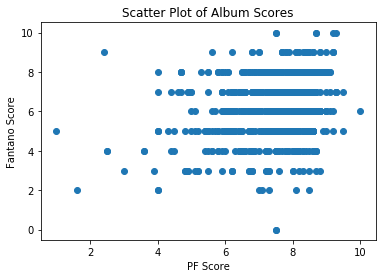

In [19]:
plt.scatter(Fantano_PF_intersec_df['score_pf'], Fantano_PF_intersec_df['score_Fantano'])
plt.ylabel('Fantano Score')
plt.xlabel('PF Score')
plt.title('Scatter Plot of Album Scores')
plt.show()

These appear to vary widely. How much does the score vary by for an typical album?

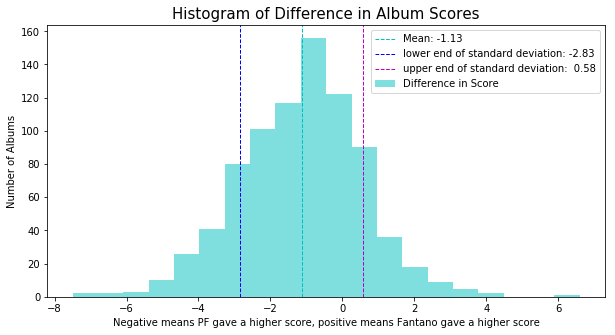

In [20]:
#create score diff df
score_diff_F_min_pf_df = Fantano_PF_intersec_df.loc[:,['artist_Fantano', 'title_Fantano']]
score_diff = Fantano_PF_intersec_df['score_Fantano'] - Fantano_PF_intersec_df['score_pf']
score_diff_F_min_pf_df['difference']= score_diff

#compute values for plot
diff_mean = score_diff_F_min_pf_df['difference'].mean()
diff_st = score_diff_F_min_pf_df['difference'].std()
diff_st_l = diff_mean - diff_st
diff_st_u = diff_mean + diff_st

#plot
plt.figure(figsize=(10,5))
plt.hist(score_diff_F_min_pf_df['difference'], color='c', alpha=.5, bins=20, label='Difference in Score')
plt.title('Histogram of Difference in Album Scores', fontsize= 15)
plt.xlabel('Negative means PF gave a higher score, positive means Fantano gave a higher score')
plt.ylabel('Number of Albums')
plt.axvline(diff_mean , color='c', linestyle='dashed', linewidth=1, label='Mean: {:5.2f}'.format(diff_mean))
plt.axvline(diff_mean - diff_st, color='b', linestyle='dashed', linewidth=1, 
            label='lower end of standard deviation: {:5.2f}'.format(diff_st_l))
plt.axvline(diff_mean + diff_st, color='m', linestyle='dashed', linewidth=1, 
            label='upper end of standard deviation: {:5.2f}'.format(diff_st_u))
plt.legend(loc='upper right')
plt.show()

The mean score given by Fantano is lower, but many albums will get a higher score from Fantano than Pitchfork. 

Let's check this is normally distributed. 

In [21]:
#create normal distribution with same size as Best New Music
normal_diff = np.random.normal(40, .1, score_diff_F_min_pf_df['difference'].count())
normal_diff.sort()

In [22]:
differences = score_diff_F_min_pf_df['difference']
differences = differences.sort_values()

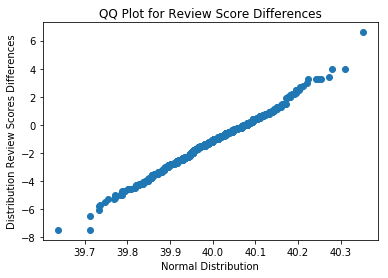

In [23]:
#plot normal distribution and Best New Music on QQ
plt.plot(normal_diff, differences, "o")
plt.xlabel('Normal Distribution')
plt.ylabel('Distribution Review Scores Differences')
plt.title('QQ Plot for Review Score Differences')
plt.show()

There are a couple of outliers, but this is close to normal.

### Pitchfork's 'Best New Music'

Pitchfork adds some of the albums that it reviews to an ongoing cumulative list call 'Best New Music'. Are the reviews scores for these albums higher than the average review? How much higher?

For this question, the reviews are considered as the population, since this is question comparing 

In [24]:
#slice best new music
pf_bnm = pf_reviews_df.loc[pf_reviews_df['best_new_music'] == 1]['score']

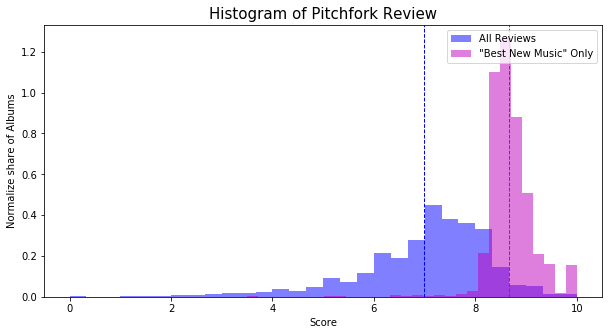

In [25]:
#plot results
plt.figure(figsize=(10,5))
plt.hist(pf_reviews_df['score'], color='b', alpha=.5, label='All Reviews', bins=30, density=True)
plt.axvline(pf_reviews_df['score'].mean(), color='b', linestyle='dashed', linewidth=1)

plt.hist(pf_bnm, color='m', alpha=.5, label='"Best New Music" Only', bins=30, density=True)
plt.axvline(pf_bnm.mean(), color='m', linestyle='dashed', linewidth=1)

plt.legend(loc='upper right')
plt.xlabel('Score')
plt.ylabel('Normalize share of Albums')
plt.title('Histogram of Pitchfork Review', fontsize=15)
plt.show()

As described above, the distribution of all reviews appears skewed. The Best New Music scores, while having a much higher mean, is a sample of all reviews and appears to be closer to normal. To test this, we will look at a Quantile-Quantile plot.

In [26]:
#create normal distribution with same size as Best New Music
normal = np.random.normal(40, .1, 1132)

#sort bnm values
pf_bnm = pf_bnm.sort_values()
normal.sort()

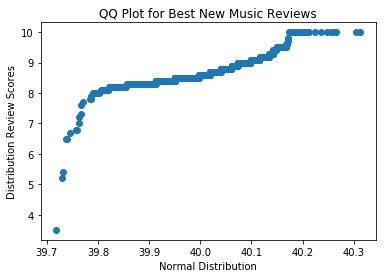

In [27]:
#plot normal distribution and Best New Music on QQ
plt.plot(normal, pf_bnm, "o")
plt.xlabel('Normal Distribution')
plt.ylabel('Distribution Review Scores')
plt.title('QQ Plot for Best New Music Reviews')
plt.show()

There is some differences, especially at the extreme ends of the distribution - a very few low scores, and a grouping of perfect 10 scores at the high end. This is likely due to the bounds of the scores - low scores in 'best new music' are contrary to the definition of 'Best' and very rare, and this tail is thin, until around a score of 8. The maximum score of 10 puts a hard limit on the right tail, limiting . 

## Proposal for Additional Research

I would be interested in getting in deeper with these data sets by genre and over time. The text of the pitchfork reviews (and the video of the Fantano reviews) seem like they would be interesting to analize for how different albums are describe, including by genre and better vs worse albums. 

I also looked into another set of reviews which was originally extracted from Amazon reviews. I think there would be interesting cluster analysis to do by looking at people who positively review a given album review other albums, and if adding in profesional reviews adds anything to this. 